### Download images

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shravankumar9892/image-colorization")

print("Path to dataset files:", path)

/opt/miniconda3/envs/color_images/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/ulrikes/.cache/kagglehub/datasets/shravankumar9892/image-colorization/versions/4


Let's inspect a few images. Imafges are stored in LAB space, so they need to be converted to RGB. 

Found 4 files.
Examples: ['/Users/ulrikes/.cache/kagglehub/datasets/shravankumar9892/image-colorization/versions/4/ab/ab/ab1.npy', '/Users/ulrikes/.cache/kagglehub/datasets/shravankumar9892/image-colorization/versions/4/ab/ab/ab3.npy', '/Users/ulrikes/.cache/kagglehub/datasets/shravankumar9892/image-colorization/versions/4/ab/ab/ab2.npy', '/Users/ulrikes/.cache/kagglehub/datasets/shravankumar9892/image-colorization/versions/4/l/gray_scale.npy']
Recreated image


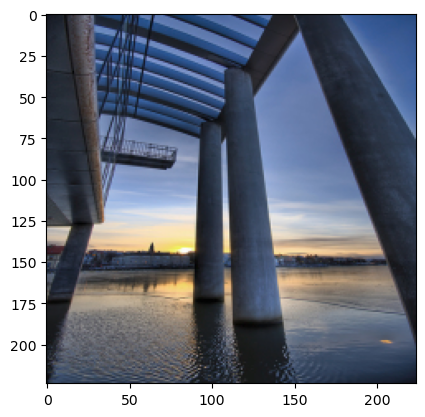

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2



# List all .npy files
files = [os.path.join(root, f)
             for root, _, files in os.walk(path)
             for f in files if f.endswith(('.npy', 'zip'))]

print(f"Found {len(files)} files.")
print("Examples:", files)



# Load grayscale L channel (assumed shape: [10000, 224, 224, 1])
images_gray = np.load(files[3])

# Load AB channels (pick one, e.g., ab1.npy)
images_lab1 = np.load(files[0])
images_lab2 = np.load(files[1])
images_lab3 = np.load(files[1])

index = 5
image_gray = images_gray[index]
image_lab = images_lab1[index]


img = np.zeros((224, 224, 3))
img[:, :, 0] = image_gray
img[:, :, 1:] = image_lab

# Changing the data type of the img array to 'uint8', opencv needs it for conversion
img = img.astype('uint8')

img_ = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)


print('Recreated image')
plt.imshow(img_)
plt.show()



Now, let's convert all of those images into RGB images


Processing 100 images...


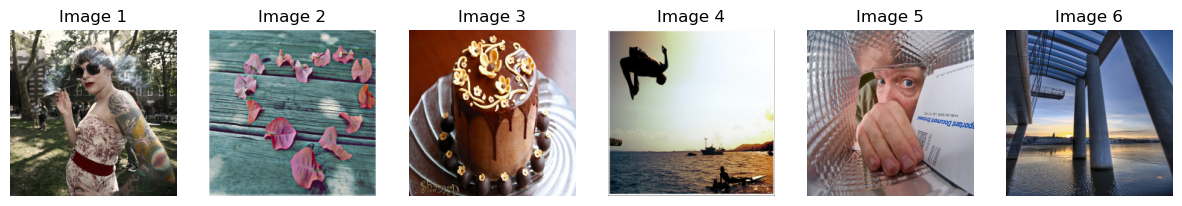

In [5]:


# Load grayscale L channel
gray_file = [f for f in files if "gray" in f][0]
images_gray = np.load(gray_file)  

# Load AB channel files (ab1, ab2, ab3)
ab_files = sorted([f for f in files if "ab" in f and "gray" not in f])
ab_arrays = [np.load(f) for f in ab_files]

# Concatenate AB arrays along the batch dimension
images_ab = np.concatenate(ab_arrays, axis=0) 

# Double check the count matches
N = min(len(images_gray), len(images_ab))
N = 100   #lets just look at 100 images for now
print(f"Processing {N} images...")

# Convert all from LAB to RGB
rgb_images = []
for i in range(N):
    L = images_gray[i]                         
    AB = images_ab[i]                          
    
    img = np.zeros((224, 224, 3))
    img[:, :, 0] = L
    img[:, :, 1:] = AB
    img = img.astype('uint8')
    img_ = cv2.cvtColor(img, cv2.COLOR_LAB2RGB) 
    rgb_images.append(img_)

# Show some RGB images
num_show = 6
plt.figure(figsize=(15, 5))
for i in range(num_show):
    plt.subplot(1, num_show, i + 1)
    plt.imshow(rgb_images[i])
    plt.axis('off')
    plt.title(f"Image {i+1}")
plt.show()


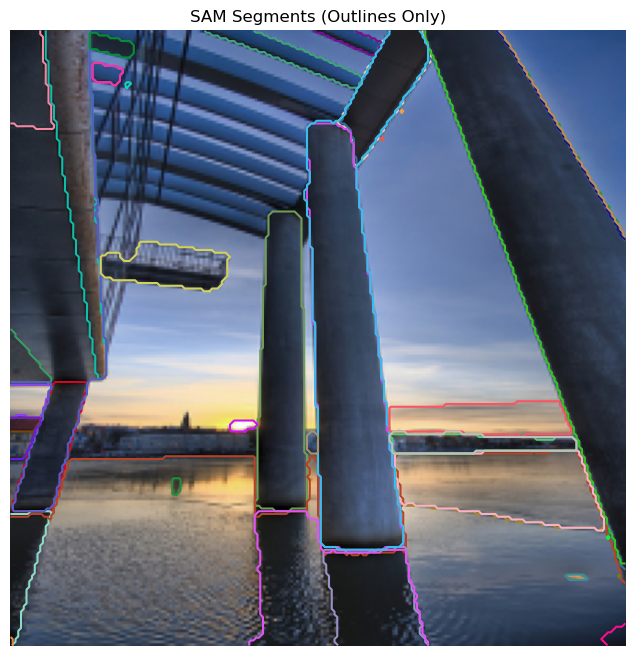

In [12]:
# Let's see what SAM does with this

import torch
from segment_anything import sam_model_registry
from segment_anything import SamAutomaticMaskGenerator
from skimage import measure


# Load SAM model (vit_b is faster; vit_h is more accurate)
sam = sam_model_registry["vit_b"](checkpoint="sam_vit_b_01ec64.pth")
sam.to("cuda" if torch.cuda.is_available() else "cpu")

mask_generator = SamAutomaticMaskGenerator(sam)
image = rgb_images[5]  # Use RGB image
masks = mask_generator.generate(image)  # This can take a few seconds

def show_sam_mask_outlines(image, masks):
    plt.figure(figsize=(8, 8))
    plt.imshow(image)

    for m in masks:
        mask = m["segmentation"]
        contours = measure.find_contours(mask, 0.5)
        for contour in contours:
            plt.plot(contour[:, 1], contour[:, 0], linewidth=1.5, color=np.random.rand(3,))

    plt.axis("off")
    plt.title("SAM Segments (Outlines Only)")
    plt.show()

show_sam_mask_outlines(image, masks)



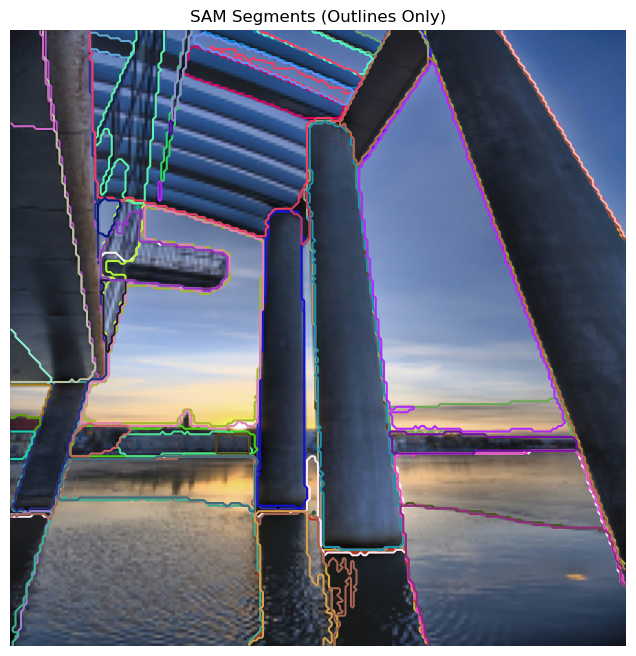

In [11]:
# not great, lets try fiddling with the parameters. 
# decrease points_per_side to increase speed, decrease prediction threshold and decrease stability score


# Load SAM model (vit_b is faster; vit_h is more accurate)
sam = sam_model_registry["vit_b"](checkpoint="sam_vit_b_01ec64.pth")
sam.to("cuda" if torch.cuda.is_available() else "cpu")

mask_generator = SamAutomaticMaskGenerator(sam)
image = rgb_images[5] 
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=16,
    pred_iou_thresh=0.5,
    stability_score_thresh=0.8,
    min_mask_region_area=500  # remove tiny segments
)

masks = mask_generator.generate(image)


show_sam_mask_outlines(image, masks)



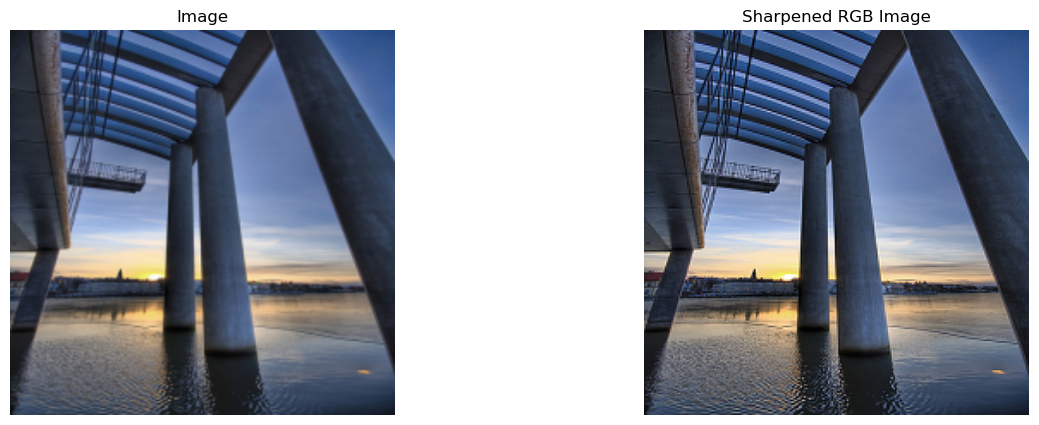

In [14]:
# images are a bit fuzzy, maybe we can sharpeb them?
L = image_gray.astype(np.float32)
AB = image_lab.astype(np.float32)


# Stack and convert


img = np.zeros((224, 224, 3))
img[:, :, 0] = L
img[:, :, 1:] = AB
img = img.astype('uint8')
rgb_image = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
rgb_image = cv2.resize(rgb_image, (512, 512)) 
# Create sharpening kernel
kernel = np.array([[0, -1,  0],
                   [-1, 5, -1],
                   [0, -1,  0]])

# Apply sharpening
sharpened = cv2.filter2D(rgb_image, -1, kernel)

# Show some RGB images
num_show = 2
plt.figure(figsize=(15, 5))
plt.subplot(1, num_show,1)
plt.imshow(rgb_image)
plt.axis('off')
plt.title(f"Image")

plt.subplot(1, num_show,2)
plt.imshow(sharpened)
plt.axis("off")
plt.title("Sharpened RGB Image")
plt.show()

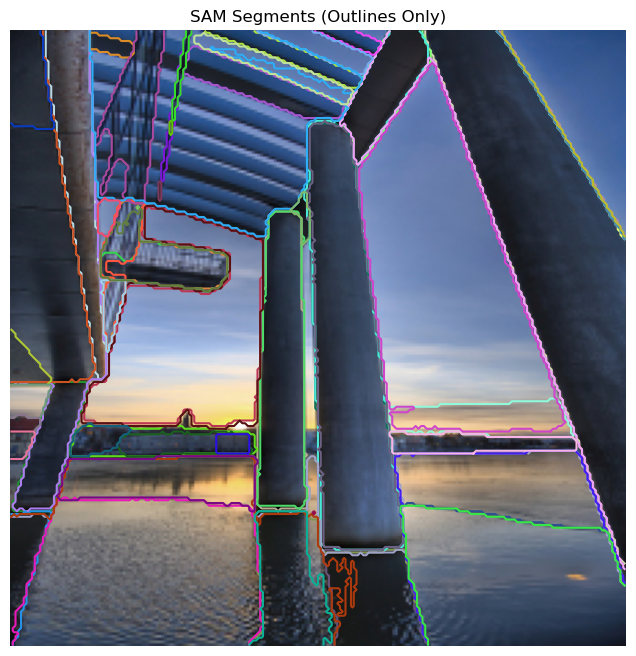

In [15]:
# Load SAM model (vit_b is faster; vit_h is more accurate)
sam = sam_model_registry["vit_b"](checkpoint="sam_vit_b_01ec64.pth")
sam.to("cuda" if torch.cuda.is_available() else "cpu")

mask_generator = SamAutomaticMaskGenerator(sam)
image = rgb_images[5] 
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=16,
    pred_iou_thresh=0.5,
    stability_score_thresh=0.8,
    min_mask_region_area=500  # remove tiny segments
)

masks = mask_generator.generate(image)


show_sam_mask_outlines(image, masks)